# Stock Valuation

This project aims to create a portfolio of stocks to buy. The priority is not to pick winning stocks, but to avoid picking losing stocks. I will aim to do this by assessing the value, growth, income and momentum of the companies in the US and UK stock market, and make a portfolio of these companies. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import requests
from IPython.display import display, clear_output
import time
from datetime import datetime, timedelta
import logging

## Company Information

This code is a template for use later on when more company information is required to assess the value of a stock.

In [2]:
# Example stock symbol
stock_symbol = 'RELX'

# Create a Ticker object
ticker = yf.Ticker(stock_symbol)

# Get stock information
info = ticker.info

# Access specific metrics
ebitda = info.get('ebitda', None)
pe_ratio = info.get('trailingPE', None)  # P/E ratio
forward_pe = info.get('forwardPE', None)  # Forward P/E ratio
peg_ratio = info.get('pegRatio', None)  # PEG ratio
price_to_book = info.get('priceToBook', None)  # Price/Book ratio
trailing_eps = info.get('trailingEps', None)  # Trailing 12-month EPS
forward_eps = info.get('forwardEps', None) 
enterprise_to_revenue = info.get('enterpriseToRevenue', None)  # Enterprise Value/Revenue
enterprise_to_ebitda = info.get('enterpriseToEbitda', None)  # Enterprise Value/EBITDA
beta = info.get('beta', None)

# Cash flow data is not directly available through the `info` attribute. 
# You need to use `cashflow` for the cash flow statement:
cash_flow_statement = ticker.cashflow

# Print the metrics
print(f"Stock: {stock_symbol}")
print(f"EBITDA: {ebitda}")
print(f"P/E Ratio: {pe_ratio}")
print(f"Forward P/E Ratio: {forward_pe}")
print(f"PEG Ratio: {peg_ratio}")
print(f"Trailing EPS: {trailing_eps}")
print(f"Forward EPS: {forward_eps}")
print(f"Price to Book Ratio: {price_to_book}")
#print(f"Enterprise to Revenue: {enterprise_to_revenue}")
#print(f"Enterprise to EBITDA: {enterprise_to_ebitda}")
print(f"Beta: {beta}")
print("\nCash Flow Statement (Annual):")
print(cash_flow_statement)

# Note: The cash flow statement provided here is annual by default. 
# You can get quarterly data by passing `quarterly=True` to `cashflow`.

Stock: RELX
EBITDA: 2894000128
P/E Ratio: 35.786324
Forward P/E Ratio: 38.063633
PEG Ratio: None
Trailing EPS: 1.17
Forward EPS: 1.1
Price to Book Ratio: 22.767809
Beta: 0.457

Cash Flow Statement (Annual):
                                         2023-12-31    2022-12-31  \
Free Cash Flow                         1980000000.0  1965000000.0   
Repurchase Of Capital Stock            -850000000.0  -550000000.0   
Repayment Of Debt                      -847000000.0   -35000000.0   
Issuance Of Debt                        651000000.0   397000000.0   
Issuance Of Capital Stock                41000000.0    26000000.0   
Capital Expenditure                    -477000000.0  -436000000.0   
End Cash Position                       155000000.0   334000000.0   
Beginning Cash Position                 334000000.0   113000000.0   
Effect Of Exchange Rate Changes         -10000000.0    13000000.0   
Changes In Cash                        -169000000.0   208000000.0   
Financing Cash Flow               

In [3]:
# Adjust display settings to show more rows
pd.set_option('display.max_rows', None)  # None means show all rows
pd.set_option('display.max_columns', None)  # Show all columns

#ticker.get_balance_sheet()

In [4]:
def calculate_croci(ticker):
    stock = yf.Ticker(ticker)
    info = stock.get_info()
    balance_sheet = stock.get_balance_sheet()

    try:
        ebitda = info.get('ebitda')  # Most recent year's EBITDA
        total_equity = balance_sheet.loc['StockholdersEquity'].iloc[0]  # Total equity

        croci = ebitda / total_equity
        return croci * 100  # Convert to percentage
    except KeyError as e:
        print(f"Data missing for {e}")
        return None

# Example usage
ticker_symbol = 'TSLA'
croci_percentage = calculate_croci(ticker_symbol)
if croci_percentage is not None:
    print(f"CROCI % (EBITDA/Total Equity) for {ticker_symbol}: {croci_percentage:.2f}%")
else:
    print("CROCI calculation not possible due to missing data.")

CROCI % (EBITDA/Total Equity) for TSLA: 21.65%


In [5]:
def calculate_price_appreciation(ticker):
    # Create a Ticker object
    stock = yf.Ticker(ticker)

    # Calculate the date 6 months ago
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)  # Approximately 6 months

    # Fetch historical data from 6 months ago to today
    data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

    if data.empty:
        print("No data available for the requested period.")
        return None

    # Retrieve the first and last closing prices within the data
    try:
        starting_price = data['Close'].iloc[0]
        ending_price = data['Close'].iloc[-1]
    except IndexError:
        print("Error retrieving stock prices.")
        return None

    # Calculate the percentage appreciation
    price_appreciation = ((ending_price - starting_price) / starting_price) * 100

    return price_appreciation

# Example usage
ticker_symbol = 'TSLA'  # Example with Apple Inc.
appreciation = calculate_price_appreciation(ticker_symbol)
if appreciation is not None:
    print(f"The stock price appreciation for {ticker_symbol} over the last 6 months is {appreciation:.2f}%")
else:
    print("Unable to calculate stock price appreciation.")

The stock price appreciation for TSLA over the last 6 months is -30.77%


In [6]:
logging.basicConfig(level=logging.ERROR)  # Suppress yfinance messages

import yfinance as yf
import numpy as np
import pandas as pd

def calculate_alpha(stock_symbol, benchmark_symbol, risk_free_rate, start_date, end_date):
    try:
        # Download stock data
        stock_info = yf.Ticker(stock_symbol).info
        market_cap = stock_info.get('marketCap')

        # Check if market cap is valid and numeric
        if market_cap is None or not isinstance(market_cap, (int, float)):
            #print(f"Invalid or missing market cap for {stock_symbol}.")
            return np.nan

        # Download stock and benchmark historical data
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)
        benchmark_data = yf.download(benchmark_symbol, start=start_date, end=end_date, progress=False)

        # Ensure both data sets are non-empty
        if stock_data.empty or benchmark_data.empty:
            return np.nan

        # Calculate daily returns and drop NaN values
        stock_returns = stock_data['Adj Close'].pct_change().dropna()
        benchmark_returns = benchmark_data['Adj Close'].pct_change().dropna()

        # Calculate covariance matrix and beta
        covariance_matrix = np.cov(stock_returns, benchmark_returns)
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]

        # Calculate expected and actual returns
        expected_returns = risk_free_rate + beta * (benchmark_returns.mean() * 252 - risk_free_rate)
        actual_returns = (1 + stock_returns.mean())**252 - 1
        alpha = actual_returns - expected_returns

        # Return alpha, scaled to percentage
        return round(alpha * 100, 2)
    except Exception as e:
        #print(f"Error calculating alpha for {stock_symbol}: {str(e)}")
        return np.nan

# Example usage:
alpha_value = calculate_alpha('CDTTW', '^GSPC', 0.035, '2022-04-19', datetime.now().strftime('%Y-%m-%d'))
print(f"Alpha: {alpha_value if alpha_value is not np.nan else 'N/A'}")

Alpha: N/A


# Value Analysis

### Information Technology Sector

In [7]:
df = pd.read_csv('us_stock_data.csv')

In [8]:
def fetch_metrics(tickers):
    unique_tickers = list(set(tickers))
    metrics = {
        'symbol': [],
        'Market Cap': [],
        'Trailing P/E': [],
        'P/B Ratio': [],
        'Trailing EPS': [],
        'Forward P/E': [],
        'Graham Metric': [],
        'Dividend Yield %': [],
        'Beta': [],
        'Alpha %': [],
        'Financial Currency': []
    }

    for ticker in unique_tickers:
        try:
            ticker_obj = yf.Ticker(ticker)
            info = ticker_obj.info

            trailingPE = float(info.get('trailingPE', np.nan))
            PB_ratio = float(info.get('priceToBook', np.nan))
            dividend_yield = info.get('dividendYield', np.nan)

            metrics['symbol'].append(ticker)
            metrics['Market Cap'].append(float(info.get('marketCap', np.nan)))
            metrics['Trailing P/E'].append(trailingPE)
            metrics['P/B Ratio'].append(PB_ratio)
            metrics['Trailing EPS'].append(float(info.get('trailingEps', np.nan)))
            metrics['Forward P/E'].append(float(info.get('forwardPE', np.nan)))
            metrics['Graham Metric'].append(trailingPE * PB_ratio)
            metrics['Dividend Yield %'].append(float(dividend_yield) * 100 if dividend_yield is not None else np.nan)
            metrics['Beta'].append(float(info.get('beta', np.nan)))
            metrics['Alpha %'].append(calculate_alpha(ticker, '^GSPC', 0.035, '2022-04-19', datetime.now().strftime('%Y-%m-%d')))
            metrics['Financial Currency'].append(info.get('financialCurrency', ''))
        
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue

    return pd.DataFrame(metrics)



def graham_valuation(stock_metrics):
    """Determines if a stock meets Benjamin Graham's criteria for investment."""
    valuation_status = {}
    for index, row in stock_metrics.iterrows():
        meets_criteria = True
        # Check Graham's criteria
        if row['Trailing P/E'] >= 15 or row['Trailing P/E'] * row['P/B Ratio'] >= 22.5:
            meets_criteria = False
        #if row['Current_Ratio'] < 2 or row['Debt_to_Equity'] >= 1:
        #    meets_criteria = False
        # EPS Growth and Dividend Yield can be considered based on availability and specific criteria
        
        valuation_status[row.name] = "Undervalued" if meets_criteria else "Not Undervalued"
    
    return valuation_status

def calculate_benchmarks(df):
    """Calculates benchmarks (median) for a DataFrame of financial metrics."""
    # Select only numeric columns for the median calculation
    numeric_df = df.select_dtypes(include=[np.number])
    return numeric_df.median().to_dict()

def compare_stock_to_benchmarks(stock_metrics, sp500_benchmarks, sector_benchmarks):
    """Compares a single stock's metrics to S&P 500 and sector benchmarks."""
    comparison = {}
    for metric in stock_metrics.index:
        comparison[metric] = {
            'Stock': stock_metrics[metric],
            'S&P 500 Median': sp500_benchmarks.get(metric, np.nan),
            'Sector Median': sector_benchmarks.get(metric, np.nan),
        }
    return comparison

In [9]:
def sector_valuation_status(value, metric, sector_benchmarks):
    """Determines valuation status of a stock based on sector medians for specific metrics."""
    # Define a list of metrics to evaluate
    metrics_to_evaluate = ['Trailing P/E', 'Forward P/E', 'P/B Ratio']
    
    # Check if the metric is one of the specified metrics for comparison
    if metric in sector_benchmarks and metric in metrics_to_evaluate:
        median = sector_benchmarks[metric]
        if value < median * 0.8:
            return 'Undervalued'
        elif value > median * 1.2:
            return 'Overvalued'
        else:
            return 'Fair Value'
    return 'N/A'  # Return 'N/A' for metrics not specified for evaluation

In [10]:
def graham_valuation_status(stock_metrics):
    """Evaluates if a stock meets Benjamin Graham's investment criteria with transition ranges."""
    status = {}

    # Attempt to convert to float, use inf if conversion fails
    try:
        pe_ratio = float(stock_metrics.get('Trailing P/E', float('inf')))
    except ValueError:
        pe_ratio = float('inf')

    try:
        pb_ratio = float(stock_metrics.get('P/B Ratio', float('inf')))
    except ValueError:
        pb_ratio = float('inf')

    # Evaluate P/E Ratio
    if pe_ratio < 15:
        status['Trailing P/E'] = 'Undervalued'
    elif 15 <= pe_ratio <= 20:
        status['Trailing P/E'] = 'Fair Value'
    else:
        status['Trailing P/E'] = 'Overvalued'

    # Evaluate P/B Ratio
    if pb_ratio < 1.5:
        status['P/B Ratio'] = 'Undervalued'
    elif 1.5 <= pb_ratio <= 2:
        status['P/B Ratio'] = 'Fair Value'
    else:
        status['P/B Ratio'] = 'Overvalued'

    # Combined P/E * P/B criterion, introducing a range for transition
    combined_value = pe_ratio * pb_ratio
    if combined_value < 22.5:
        status['Combined P/E x P/B'] = 'Undervalued'
    elif 22.5 <= combined_value <= 27:
        status['Combined P/E x P/B'] = 'Fair Value'
    else:
        status['Combined P/E x P/B'] = 'Overvalued'

    return status

In [11]:
def plot_table_colored(df):
    # Adjust the figure size here (width, height) to make the table bigger
    fig, ax = plt.subplots(figsize=(20, len(df) * 0.5))  # Adding +2 for a bit more space
    ax.axis('tight')
    ax.axis('off')
    
    # Use a larger font size for readability
    plt.rcParams.update({'font.size': 10})
    
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.1 for _ in df.columns])  # Adjust column widths as necessary
    
    # Apply coloring based on valuation status
    for i, col in enumerate(df.columns):
        for j, _ in enumerate(df.index):
            cell_text = table[(j+1, i)].get_text().get_text()
            if "Graham Status" in col:
                # Use one color scheme for Graham-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('green')  # Light blue
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('red')  # Light coral
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('orange')  # Light green
            elif "Sector Status" in col:
                # Use a different color scheme for sector-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#006400')  # Dark green
                    table[(j+1, i)].set_text_props(color='w')
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#8b0000')  # Dark red
                    table[(j+1, i)].set_text_props(color='w')
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('#808080')  # Grey
                    table[(j+1, i)].set_text_props(color='w')
            else:
                # Neutral color for non-valued cells
                table[(j+1, i)].set_facecolor('#f5f5f5')
    
    plt.tight_layout()
    plt.show()

In [12]:
# Extract unique sectors from the 'GICS Sector' column
unique_sectors = df['sector'].unique()

# Convert the array of unique sectors to a list
sector_list = unique_sectors.tolist()

# Print the list of sectors
print(sector_list)

['Healthcare', 'Basic Materials', 'Consumer Defensive', 'Financial Services', 'Industrials', 'Technology', 'Consumer Cyclical', 'Real Estate', 'Energy', 'Communication Services', 'Utilities']


In [13]:
def process_sector(sector_name, df):
    print(f"Processing sector: {sector_name}")
    sector_companies = df[df['sector'] == sector_name]['symbol'].tolist()
    sector_data = fetch_metrics(sector_companies)
    sector_benchmarks = calculate_benchmarks(sector_data)
    
    results = []
    for _, metrics in sector_data.iterrows():
        graham_status = graham_valuation_status(metrics)
        
        # Applying sector valuation status only to specific metrics
        sector_status = {metric: sector_valuation_status(metrics[metric], metric, sector_benchmarks) 
                         for metric in ['Trailing P/E', 'Forward P/E', 'P/B Ratio'] if metric in metrics}
        
        row = {
            'Ticker': metrics['symbol'],  # Assuming 'symbol' is part of the metrics DataFrame
            **metrics,
            **{f'{metric} Graham Status': status for metric, status in graham_status.items()},
            **{f'{metric} Sector Status': status for metric, status in sector_status.items()}
        }
        results.append(row)

    df_results = pd.DataFrame(results)

    return df_results, len(sector_companies) 

In [14]:
def main_process(df):
    unique_sectors = df['sector'].unique()
    total_sectors = len(unique_sectors)
    processed_count = 0
    start_time = time.time()
    
    sector_results_dict = {}

    for sector in unique_sectors:
        df_sector_results, num_stocks = process_sector(sector, df)
        sector_results_dict[sector] = df_sector_results
        
        processed_count += 1
        stocks_remaining = sum(df[df['sector'] == s]['symbol'].count() for s in unique_sectors[processed_count:])  # Calculate remaining stocks

        # Dynamic update of the progress
        clear_output(wait=True)
        display(f"Processed {processed_count}/{total_sectors} sectors. ({processed_count/total_sectors * 100:.2f}%) - "
                f"Total stocks processed in current sector: {num_stocks}")

    print("All sectors processed successfully.")
    return sector_results_dict

# Example usage assuming 'df' is your DataFrame loaded with stock data including sectors
sector_results = main_process(df)

'Processed 11/11 sectors. (100.00%) - Total stocks processed in current sector: 101'

All sectors processed successfully.


In [15]:
# Initialize the dictionary to store undervalued stocks by sector
undervalued_stocks_by_sector = {}

# Initialize an empty DataFrame to store results from all sectors
all_sectors_df = pd.DataFrame()

for sector in unique_sectors:
    # Access the pre-processed DataFrame for each sector from sector_results_dict
    df_sector_results = sector_results.get(sector, pd.DataFrame())

    if not df_sector_results.empty:
        # Extract tickers of undervalued stocks based on the "Combined P/E x P/B Graham Status"
        undervalued_stocks = df_sector_results[df_sector_results['Combined P/E x P/B Graham Status'] == 'Undervalued'].copy()
        
        # Add sector information to each row safely using .loc
        undervalued_stocks.loc[:, 'sector'] = sector
        
        # Append the undervalued stocks of the current sector to the all_sectors_df DataFrame
        all_sectors_df = pd.concat([all_sectors_df, undervalued_stocks], ignore_index=True)
    
        # Calculate and print the number of undervalued stocks per sector
        undervalued_stocks_by_sector[sector] = undervalued_stocks['Ticker'].tolist()
        print(f'Sector: {sector} - Undervalued stocks: {len(undervalued_stocks_by_sector[sector])} ({100*len(undervalued_stocks_by_sector[sector])/len(df_sector_results):.1f}%)')

# Save the consolidated DataFrame to CSV
all_sectors_df.to_csv('undervalued_stocks_by_sector.csv', index=False)

Sector: Healthcare - Undervalued stocks: 33 (2.8%)
Sector: Basic Materials - Undervalued stocks: 43 (19.9%)
Sector: Consumer Defensive - Undervalued stocks: 41 (17.5%)
Sector: Financial Services - Undervalued stocks: 445 (46.5%)
Sector: Industrials - Undervalued stocks: 86 (13.8%)
Sector: Technology - Undervalued stocks: 54 (7.1%)
Sector: Consumer Cyclical - Undervalued stocks: 97 (17.5%)
Sector: Real Estate - Undervalued stocks: 48 (19.5%)
Sector: Energy - Undervalued stocks: 94 (43.3%)
Sector: Communication Services - Undervalued stocks: 41 (16.7%)
Sector: Utilities - Undervalued stocks: 21 (20.8%)


In [26]:
#all_sectors_df[all_sectors_df['sector'] == 'Technology'].sort_values(by='P/B Ratio', ascending=True)

filtered_df = all_sectors_df[(all_sectors_df['Forward P/E'] >= 0) & (all_sectors_df['Alpha %'] > 1.5) & 
(all_sectors_df['Financial Currency'] == 'USD') & (all_sectors_df['Market Cap'] > 1e6)]
sorted_filtered_df = filtered_df.sort_values(by='Forward P/E', ascending=True)
sorted_filtered_df

Ticker symbol    Market Cap  Trailing P/E  P/B Ratio  Trailing EPS  \
858    TNP    TNP  7.320339e+08      2.170603   0.455514        11.430   
582    NMM    NMM  1.268349e+09      2.984375   0.467252        14.080   
856   DLNG   DLNG  1.277036e+08      5.102941   0.397571         0.680   
921    PXS    PXS  4.855325e+07      1.573129   0.505078         2.940   
528    JXN    JXN  5.171944e+09      6.273234   0.550957        10.760   
478   MFIN   MFIN  1.815282e+08      3.261604   0.506056         2.370   
698   CXAI   CXAI  7.342562e+07      1.246479   0.845272         2.840   
692   SURG   SURG  6.581639e+07      2.473333   1.740541         1.380   
646    UAL    UAL  1.778495e+10      6.604396   1.935657         8.190   
252   IGIC   IGIC  6.130172e+08      5.217647   1.072984         2.550   
897    TNK    TNK  1.931083e+09      3.810902   1.265390        14.860   
847   TRMD   TRMD  3.057714e+09      4.385027   1.689938         7.480   
710    BZH    BZH  8.431951e+08      5.282609   0.722686         5.060   
742   JAKK   JAKK  2.426400e+08      6.456896   1.197697         3.480   
930   CIVI   CIVI  7.431105e+09      8.155210   1.115949         9.020   
883   INSW   INSW  2.631993e+09      4.781333   1.532959        11.250   
451   HRTG   HRTG  2.876839e+08      5.502891   1.255771         1.730   
879   GPOR   GPOR  2.861770e+09      2.380096   1.338429        66.470   
871   ARLP   ARLP  2.709792e+09      4.399169   1.466288         4.810   
933    DHT    DHT  1.816564e+09     11.373737   1.764890         0.990   
139     EG     EG  1.630925e+10      6.222674   1.231467        60.200   
638    NAT    NAT  7.886225e+08      8.036170   1.465089         0.470   
777   CAAS   CAAS  1.065827e+08      2.824720   0.309430         1.250   
564    CPA    CPA  4.290259e+09      7.919317   2.024393        12.890   
662   YALA   YALA  7.288550e+08      8.330357   1.311867         0.560   
736   VIRC   VIRC  1.710745e+08      7.809701   1.876120         1.340   
349    AXS    AXS  5.292962e+09     15.547264   1.130956         4.020   
185    UNM    UNM  9.977065e+09      7.997693   1.041554         6.500   
812    ACR    ACR  1.075942e+08     40.000000   0.239710         0.350   
586   PKOH   PKOH  3.101701e+08      8.724264   1.043031         2.720   
379   HGBL   HGBL  9.190350e+07      7.575757   1.504212         0.330   
881    FRO    FRO  5.104745e+09      6.514204   2.241008         3.520   
277    WAL    WAL  6.470872e+09      8.980123   1.090258         6.540   
908   CEIX   CEIX  2.519231e+09      4.299393   1.894356        19.790   
212   ORRF   ORRF  2.806342e+08      7.665204   1.049608         3.420   
577   PANL   PANL  3.242451e+08     11.965518   0.995696         0.580   
575    ASC    ASC  6.686598e+08      5.940553   1.237330         2.710   
340   NECB   NECB  2.175276e+08      4.658133   0.709306         3.320   
192   ENVA   ENVA  1.687564e+09     11.183061   1.440048         5.490   
201    RNR    RNR  1.197734e+10      4.347235   1.375493        52.270   
748    MHO    MHO  3.150385e+09      7.001851   1.251875        16.210   
272   SSBK   SSBK  2.148343e+08      6.852692   0.994941         3.530   
360    AMG    AMG  5.266067e+09      9.314007   1.501356        17.420   
590    ULH    ULH  8.968806e+08      9.657224   1.683623         3.530   
603   GASS   GASS  2.086780e+08      4.766129   0.379552         1.240   
523    GNW    GNW  2.656530e+09     37.781250   0.339702         0.160   
581    DAL    DAL  3.166546e+10      6.291026   2.821412         7.800   
291   NMIH   NMIH  2.458532e+09      7.945312   1.281233         3.840   
796   TMHC   TMHC  5.858976e+09      7.914041   1.111223         6.980   
720    ABG    ABG  4.408209e+09      7.603688   1.369708        28.740   
741    GPI    GPI  3.659317e+09      6.336842   1.353796        42.750   
494   SPNT   SPNT  2.084849e+09      6.637837   0.892247         1.850   
922   LBRT   LBRT  3.705507e+09      8.144689   1.949242         2.730   
278   TB

In [17]:
def plot_valuation_table(df):
    print(f"Valuation Table")
    columns_to_display = ['symbol'] + [col for col in df.columns if 'Status' in col]
    plot_table_colored(df[columns_to_display])

def plot_sector_valuation_table(df, sector_name):
    print(f"Valuation Table for {sector_name} Sector")
    # Filter the DataFrame for the given sector
    sector_df = df[df['sector'] == sector_name]
    
    # Select columns that include 'Status' in their names plus the 'symbol' column
    columns_to_display = ['symbol'] + [col for col in sector_df.columns if 'Status' in col]
    
    # Plot the table with the filtered DataFrame
    plot_table_colored(sector_df[columns_to_display])

In [18]:
#plot_valuation_table(all_sectors_df)

In [19]:
def plot_pe_ratios(df, sector_name):
    plt.figure(figsize=(14, 7))
    plt.title(f'P/E Ratios for {sector_name} Sector')
    plt.xlabel('Company Ticker')
    plt.ylabel('Trailing P/E Ratio')

    # Determine colors based on valuation status
    colors = df['Combined P/E x P/B Graham Status'].map({
        'Undervalued': 'green',
        'Fair Value': 'orange',
        'Overvalued': 'red',
        'N/A': 'gray'
    })

    # Plot each company's P/E ratio
    plt.scatter(df['Ticker'], df['Trailing P/E'], color=colors, alpha=0.7, s=100)

    # Optional: Add sector median P/E ratio line
    sector_median_pe = df['Trailing P/E'].median()
    plt.axhline(y=sector_median_pe, color='blue', linestyle='--', label=f'Sector Median P/E: {sector_median_pe:.2f}')

    plt.xticks(rotation=90)  # Rotate company tickers for better readability
    plt.legend()
    plt.tight_layout()
    plt.show()

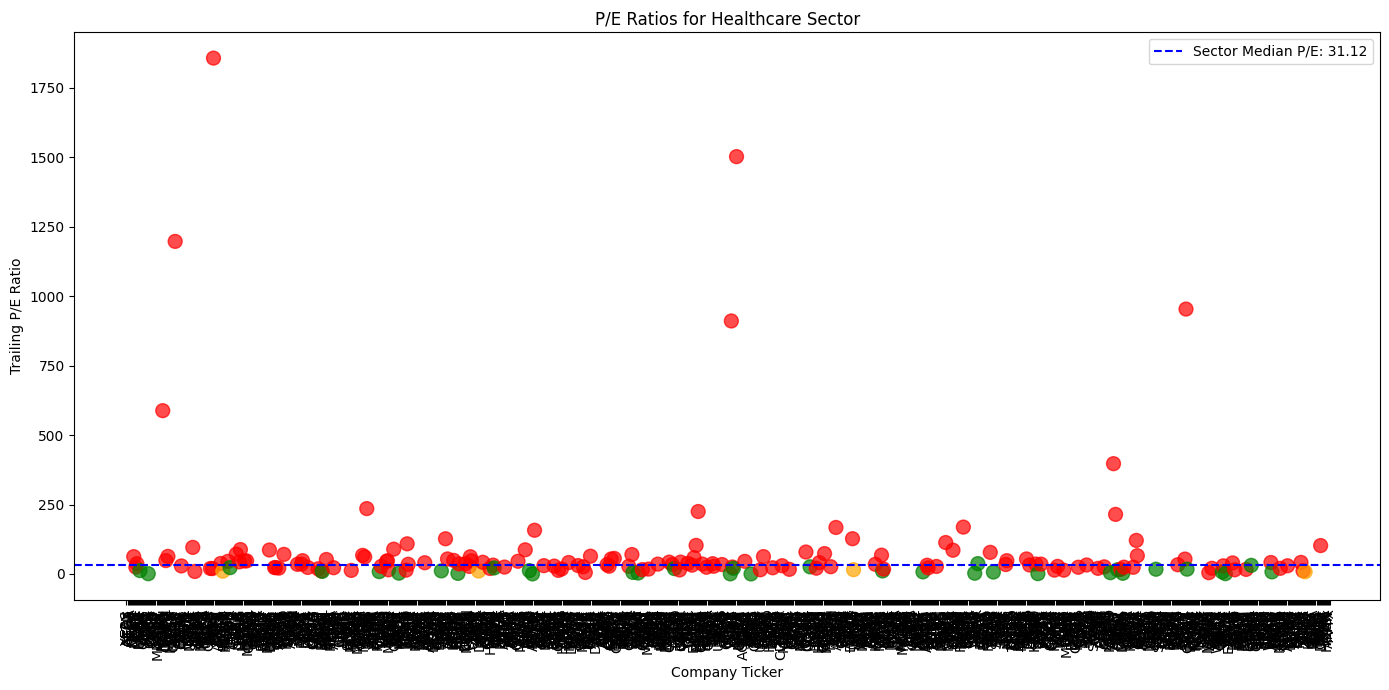

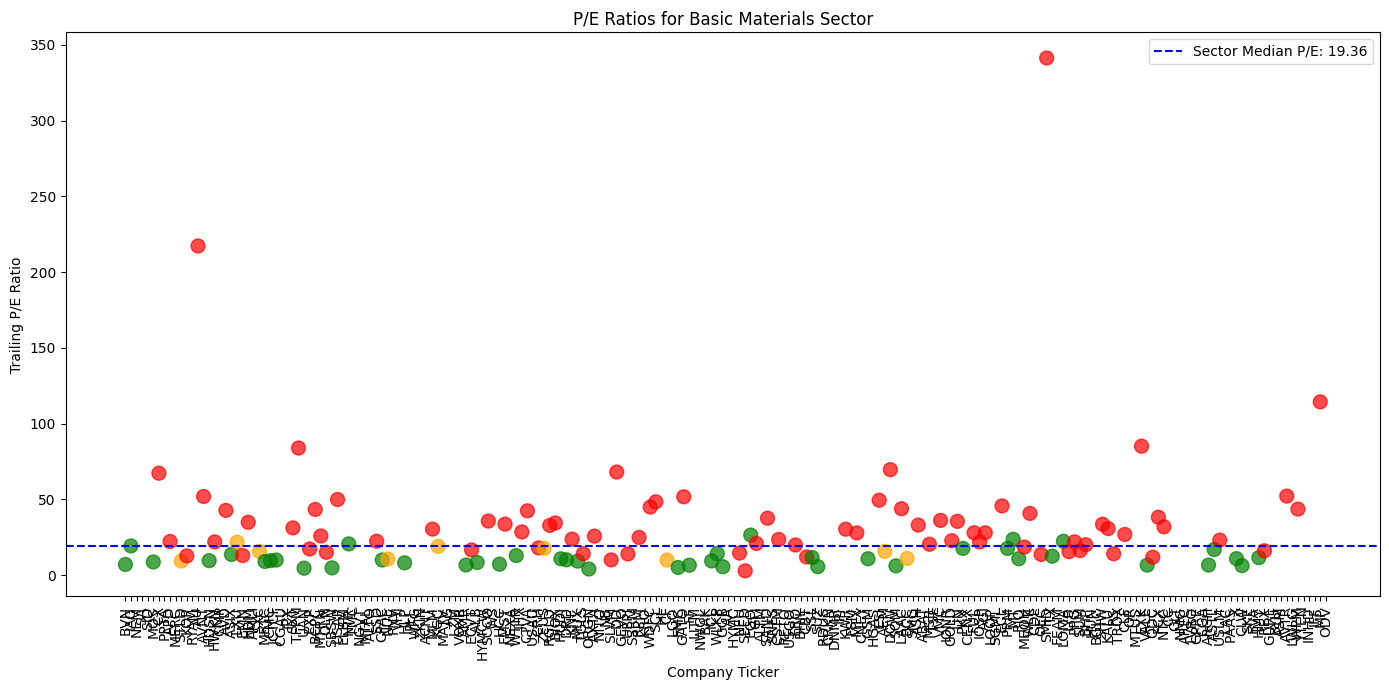

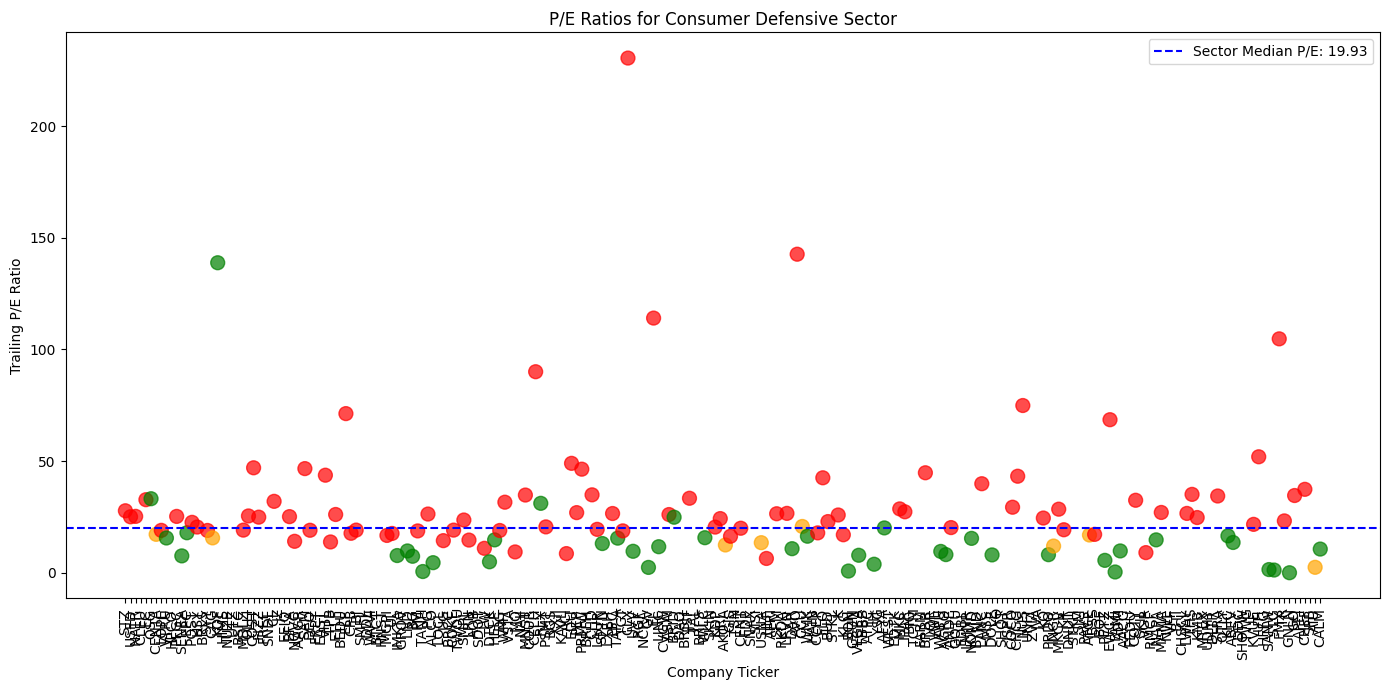

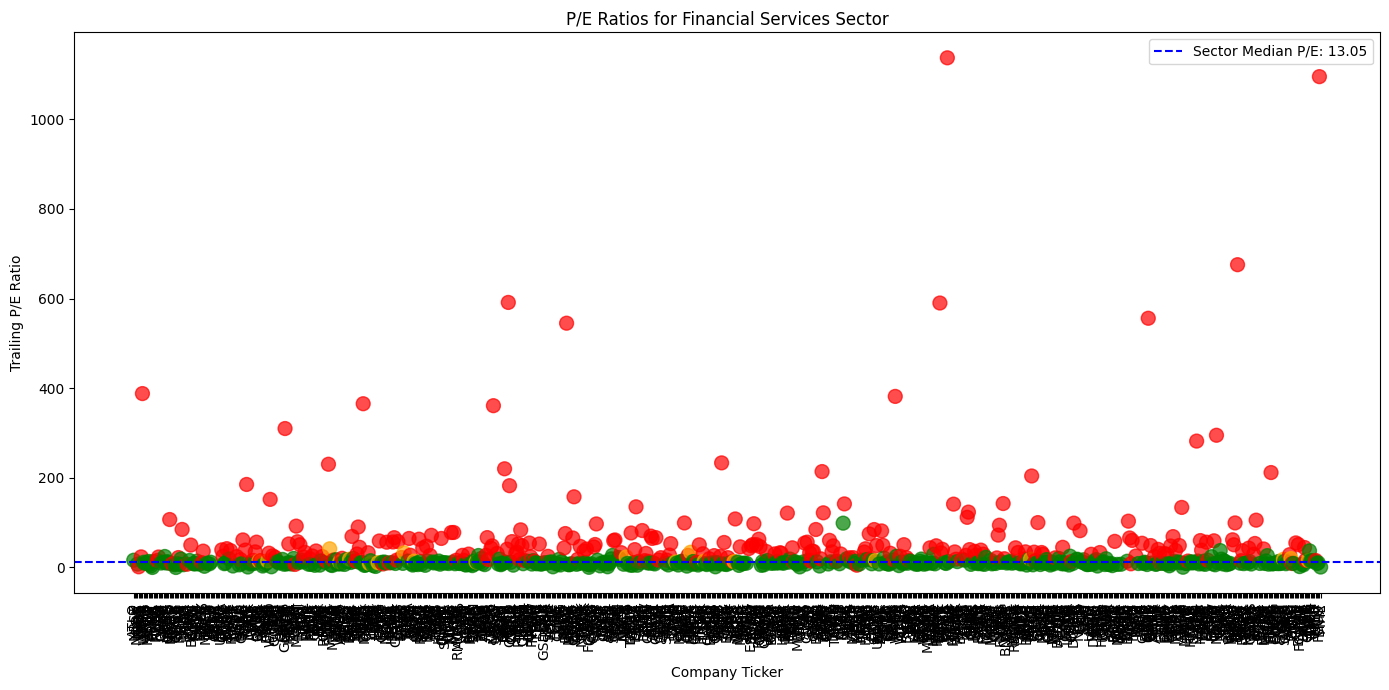

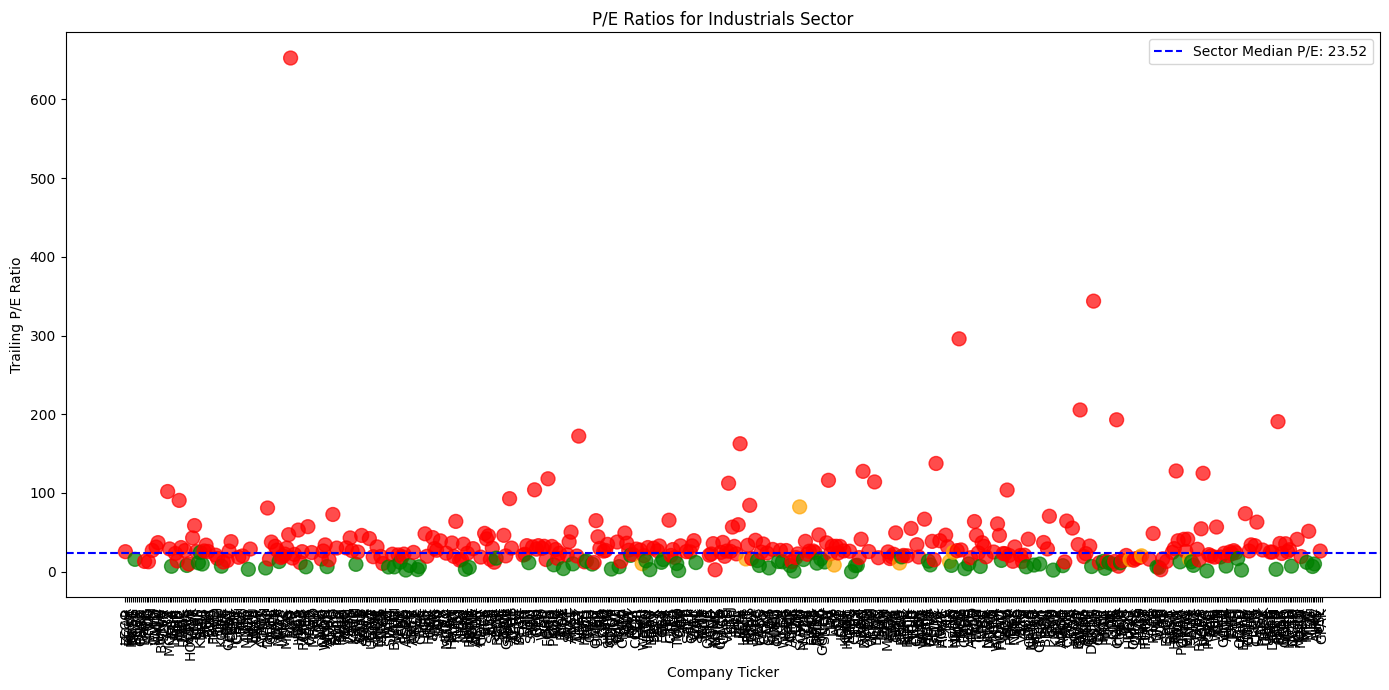

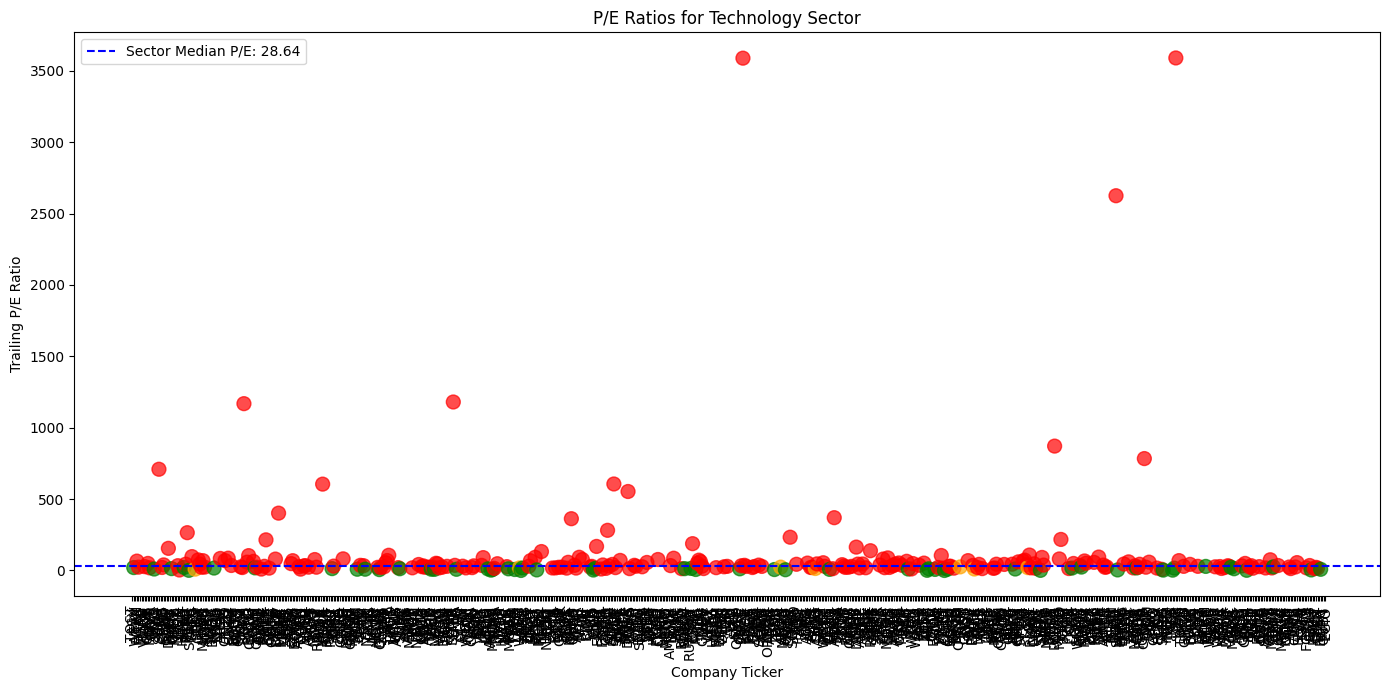

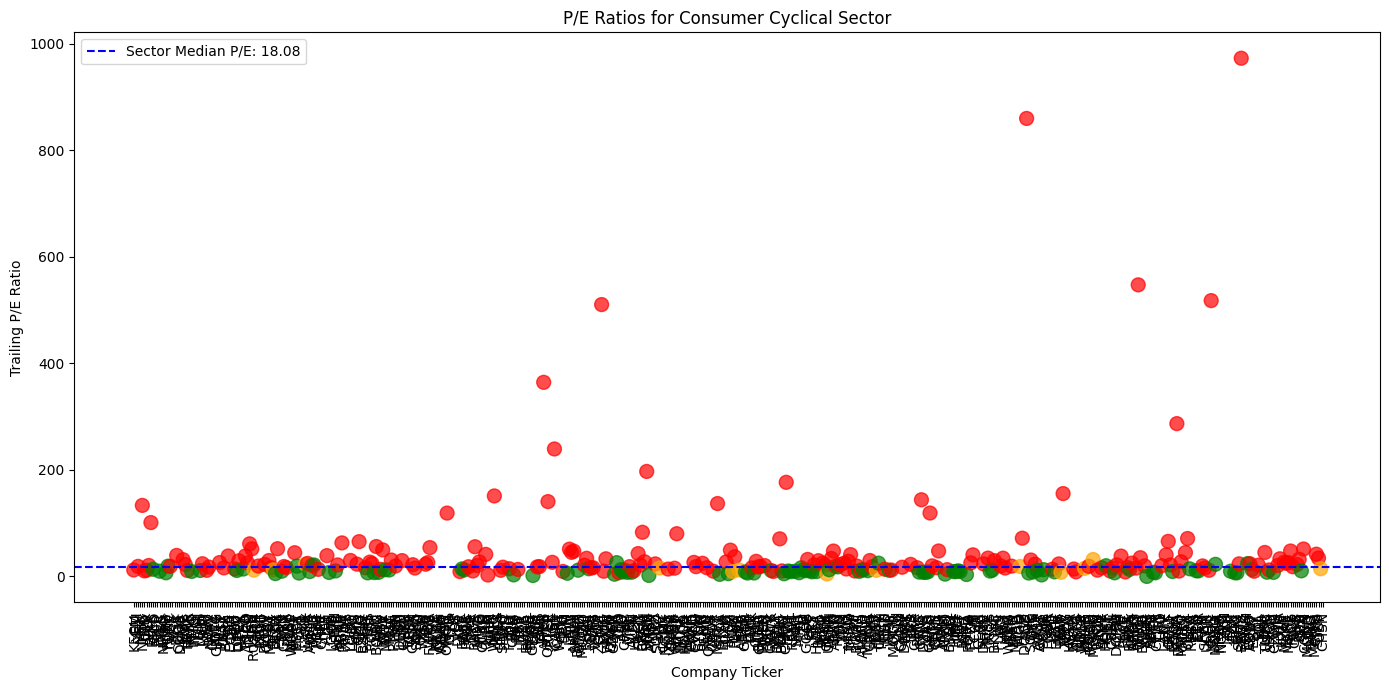

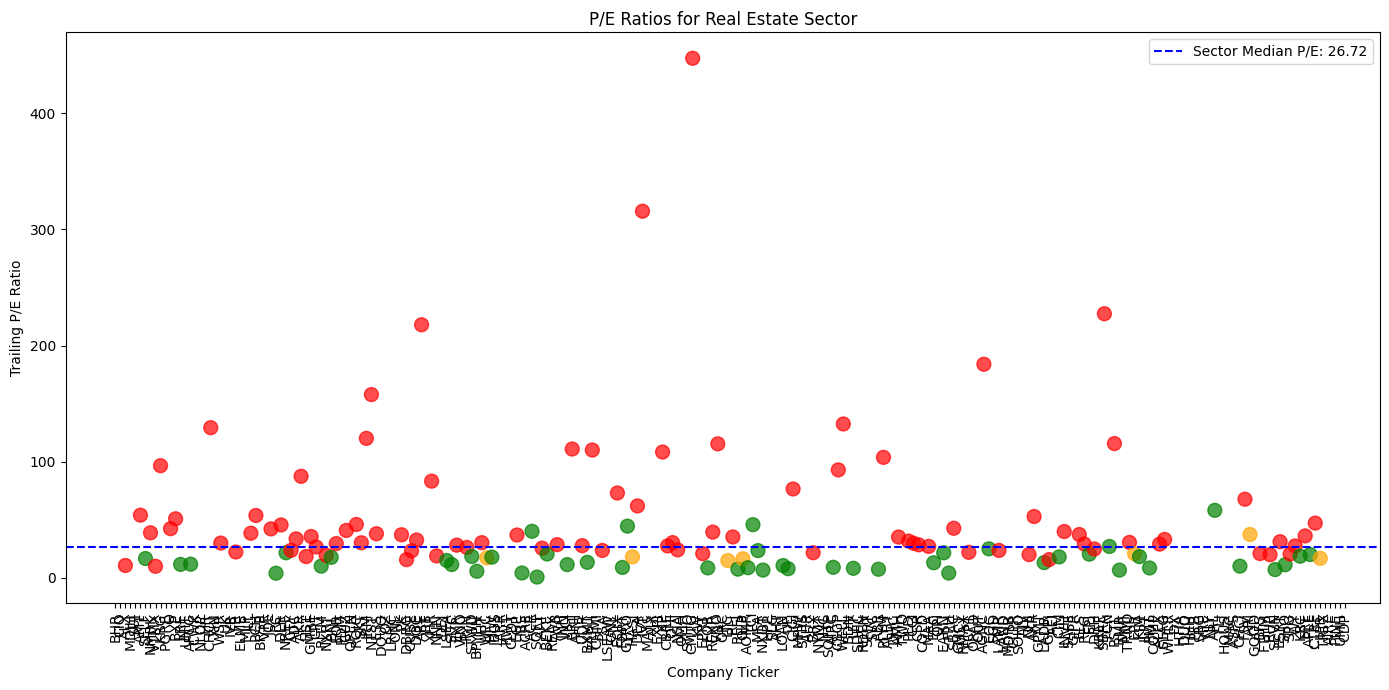

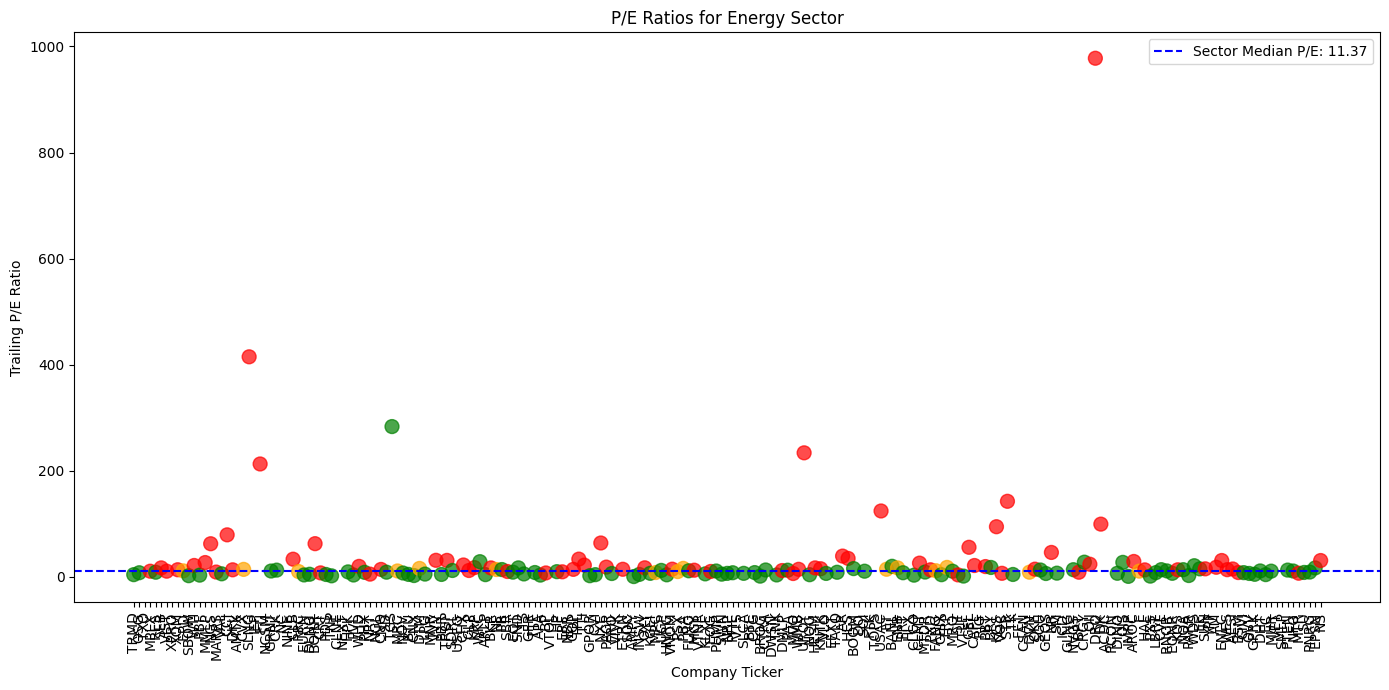

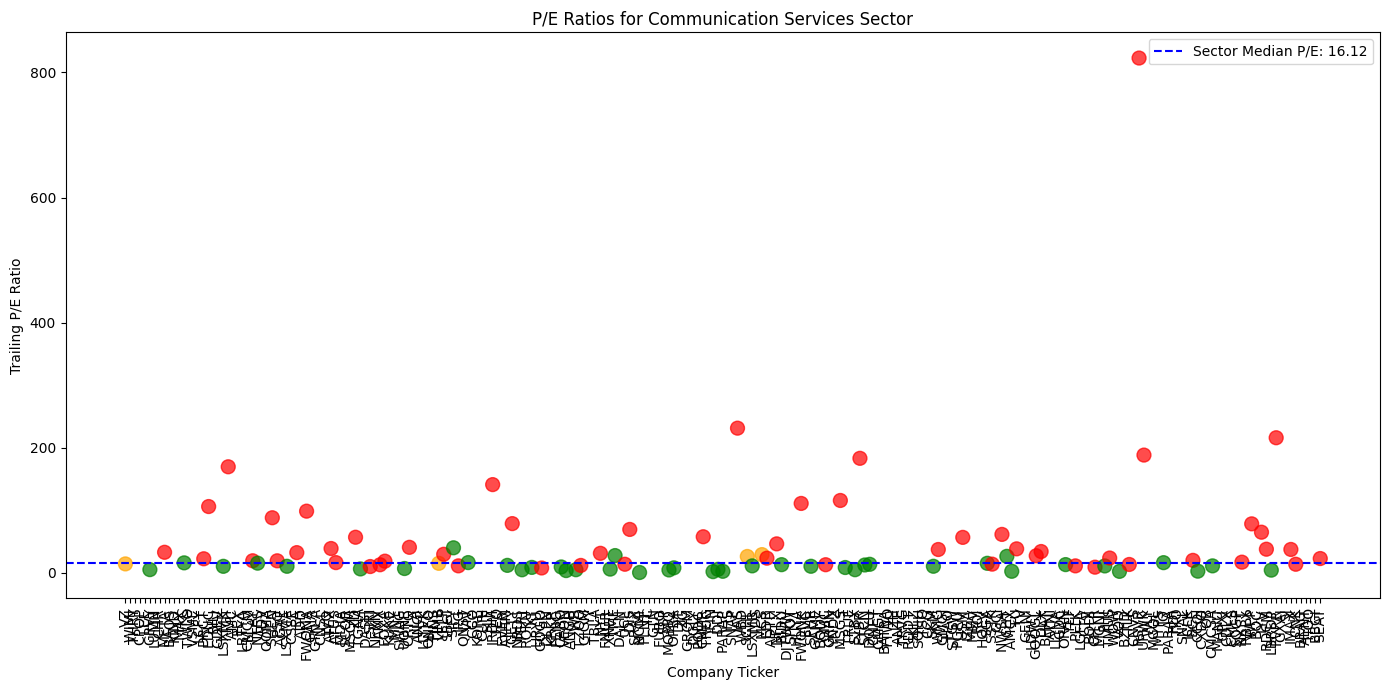

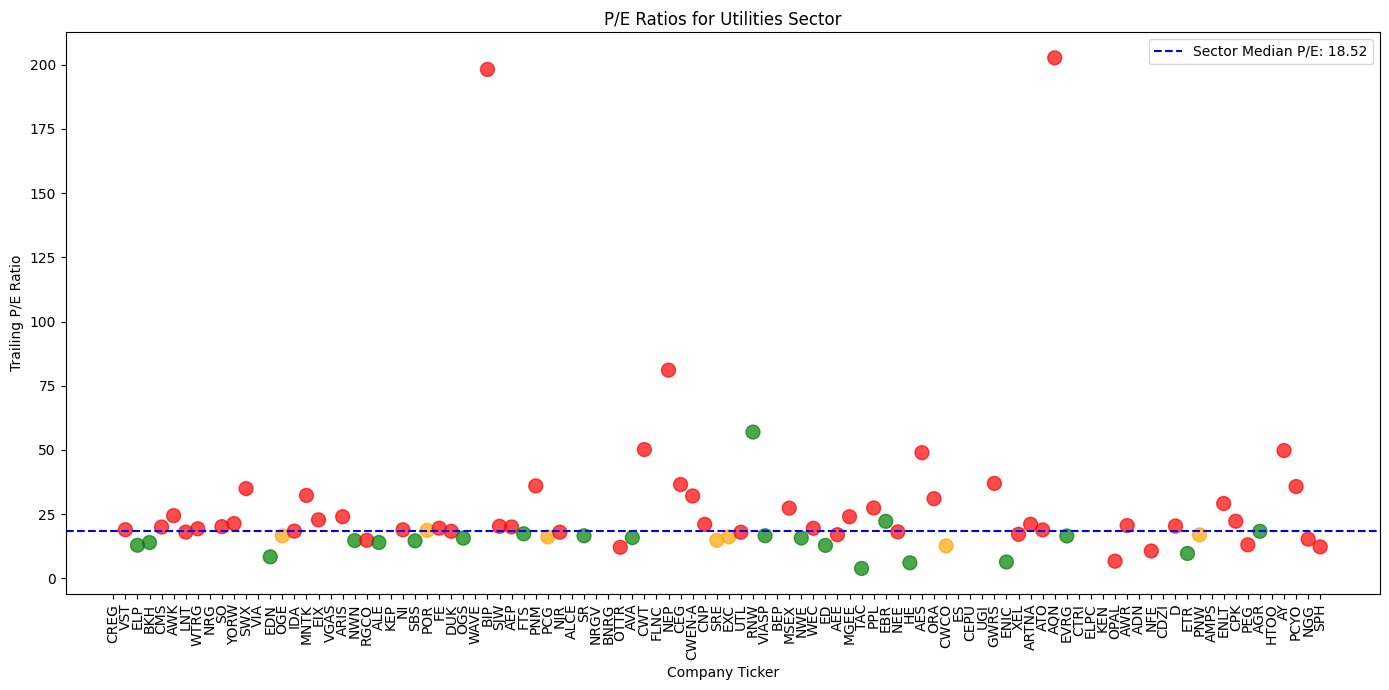

In [20]:
for sector in unique_sectors:
    df_sector_results = sector_results.get(sector, pd.DataFrame())
    plot_pe_ratios(df_sector_results, sector)

In [21]:
import numpy as np

def plot_pe_pb_with_marketcap(df):
    # Ensure Market Cap is in a suitable scale (e.g., billions) and convert to a size for the plot
    df['MarketCap_Billions'] = df['Market Cap'] / 1e9
    sizes = df['MarketCap_Billions'] * 10  # Scale market cap sizes for visibility

    # Create the scatter plot
    plt.figure(figsize=(14, 8))
    plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')
    
    # Loop through the DataFrame and add ticker symbols as text labels for each bubble
    for i, row in df.iterrows():
        # Check if both PB_Ratio and Trailing P/E are finite numbers
        if np.isfinite(row['P/B Ratio']) and np.isfinite(row['Trailing P/E']):
            plt.text(row['P/B Ratio'], row['Trailing P/E'], row['Ticker'], 
                     ha='center', va='center', fontsize=8, color='black', alpha=0.7)
    
    plt.title('P/B Ratio vs. Trailing P/E with Market Cap Size Indicator')
    plt.xlabel('P/B Ratio')
    plt.ylabel('Trailing P/E Ratio')
    plt.xscale('log')  # Using log scale for P/B Ratio if wide range values are expected
    plt.yscale('log')  # Using log scale for P/E Ratio to handle wide range of values and outliers

    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [22]:
'''
******
Use this if you want to plot all the data in one figure, but it gets quite messy
******

# Initialize an empty DataFrame
all_sectors_df = pd.DataFrame()

for sector, df in sector_results_dict.items():
    # Optionally, add a sector column to each sector's DataFrame before concatenation
    df['Sector'] = sector
    # Concatenate the current sector's DataFrame to the comprehensive DataFrame
    all_sectors_df = pd.concat([all_sectors_df, df], ignore_index=True)
'''

"\n******\nUse this if you want to plot all the data in one figure, but it gets quite messy\n******\n\n# Initialize an empty DataFrame\nall_sectors_df = pd.DataFrame()\n\nfor sector, df in sector_results_dict.items():\n    # Optionally, add a sector column to each sector's DataFrame before concatenation\n    df['Sector'] = sector\n    # Concatenate the current sector's DataFrame to the comprehensive DataFrame\n    all_sectors_df = pd.concat([all_sectors_df, df], ignore_index=True)\n"

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


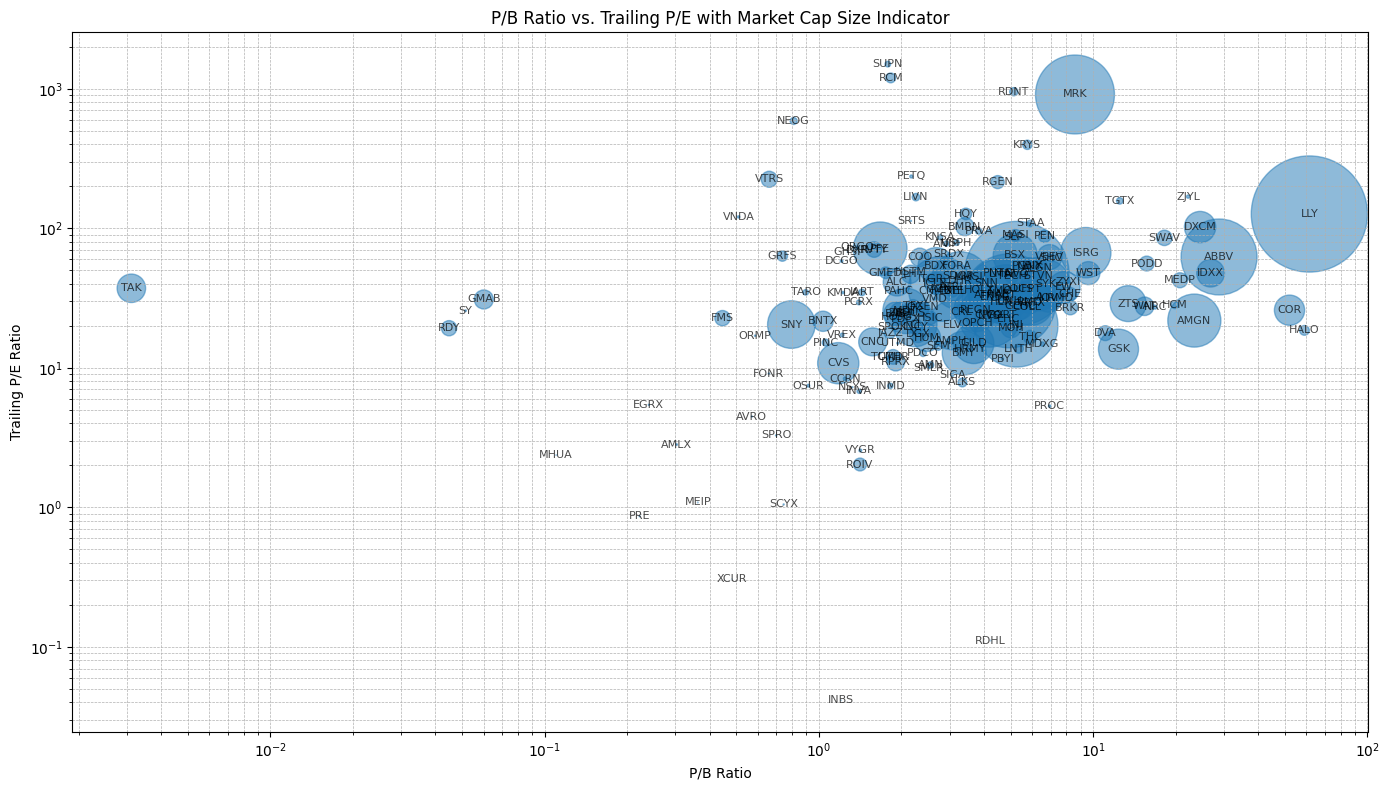

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


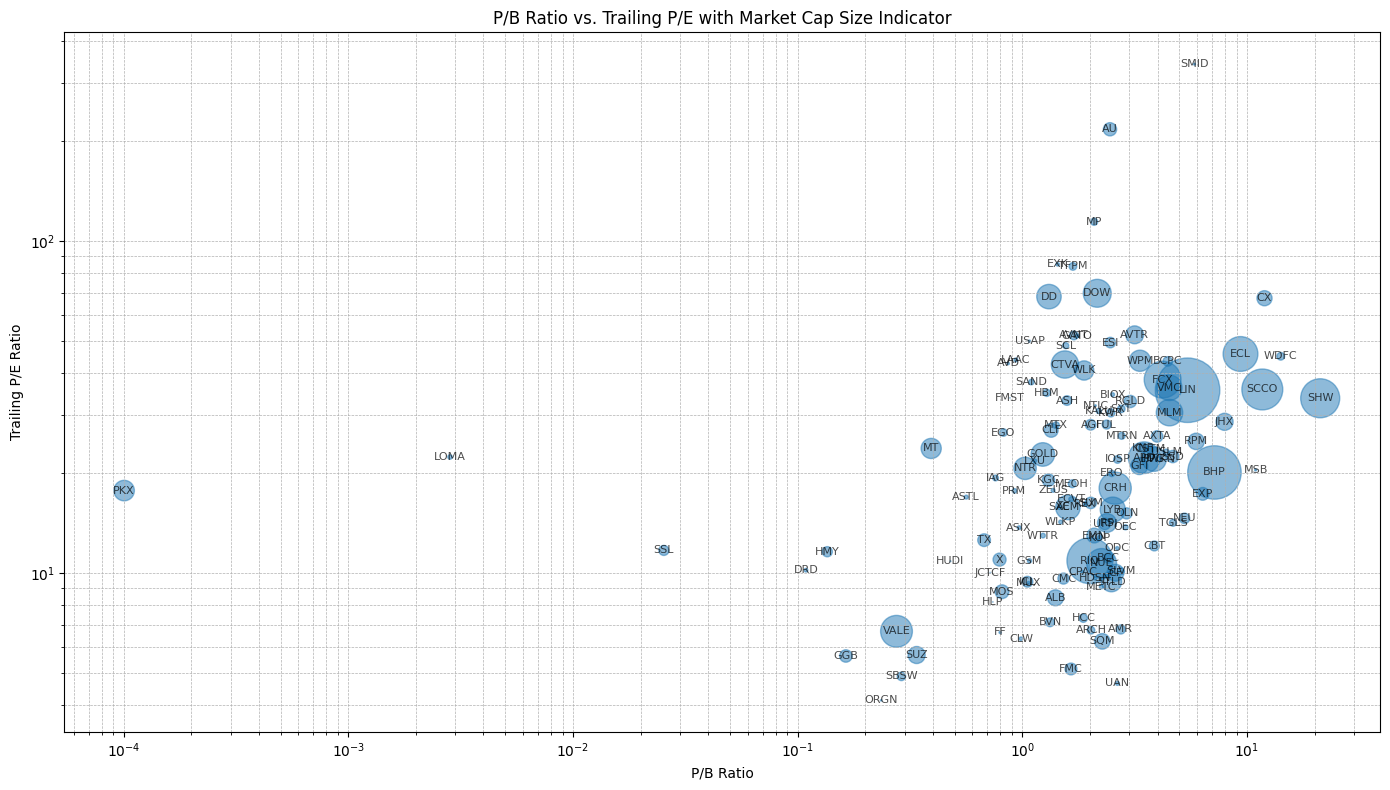

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


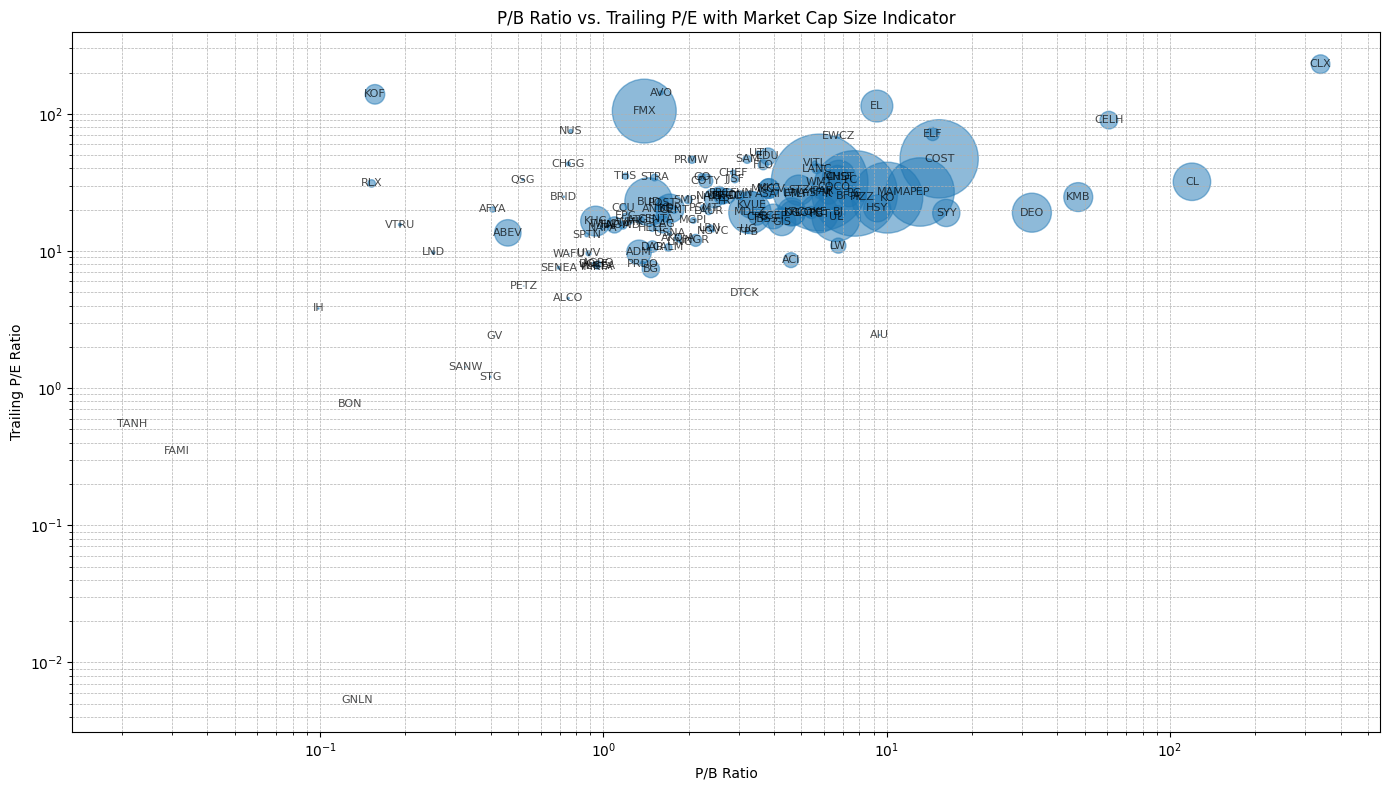

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


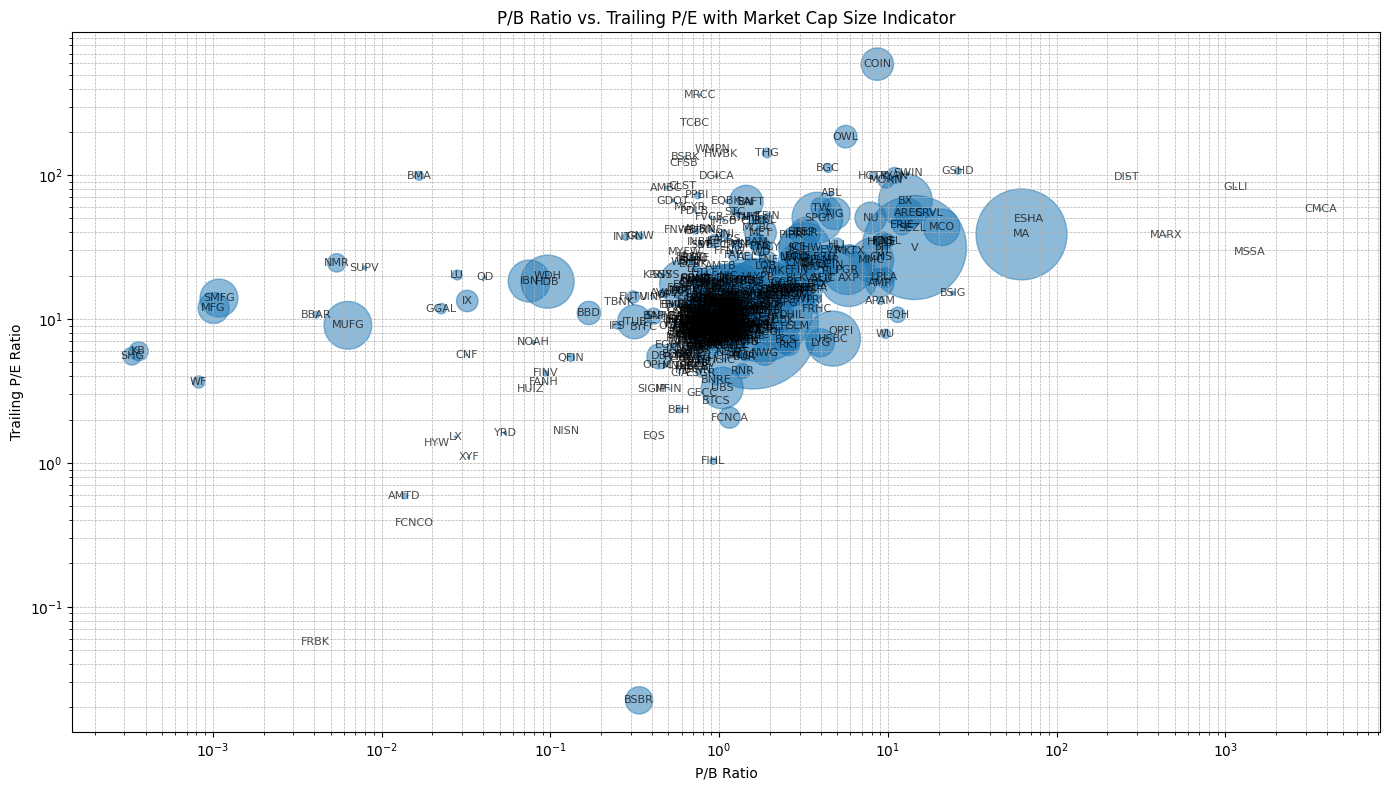

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


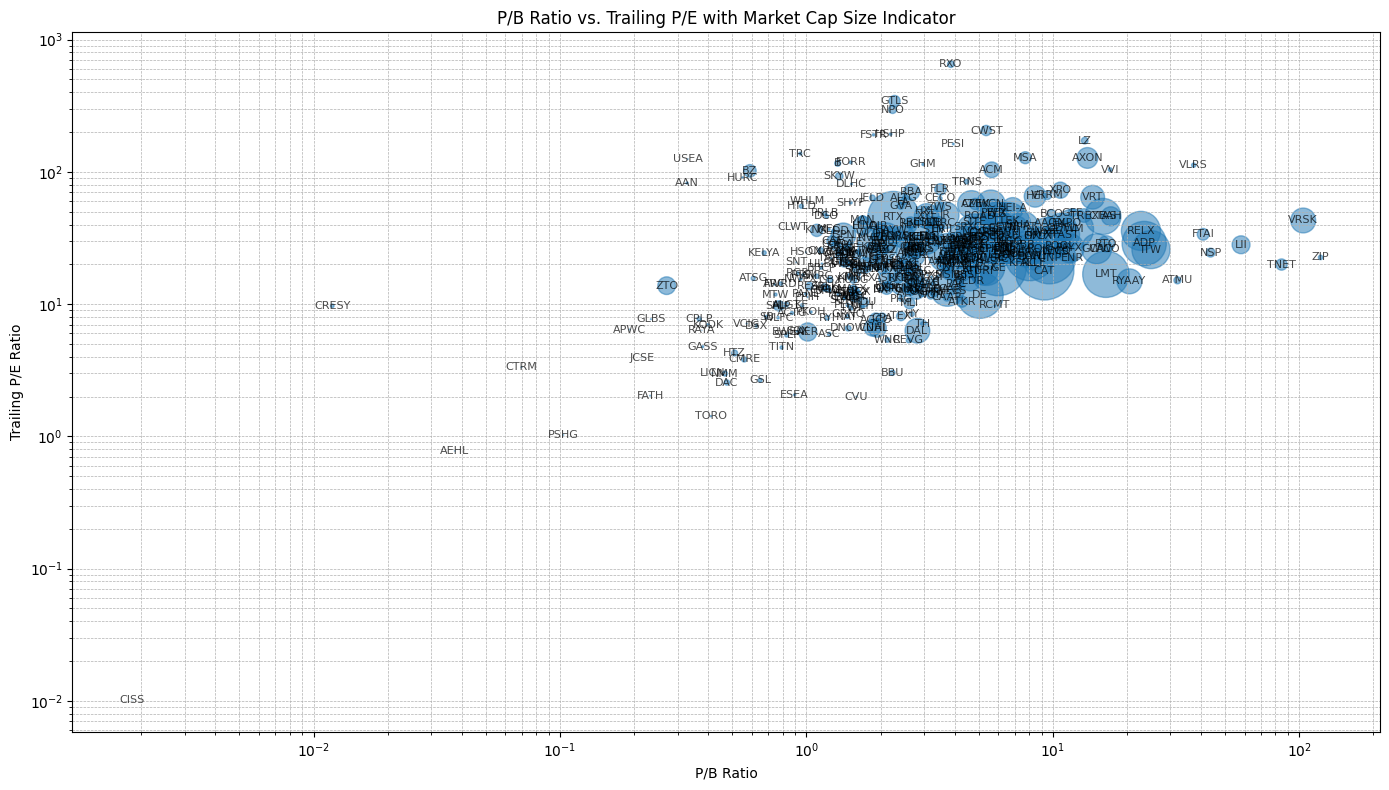

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


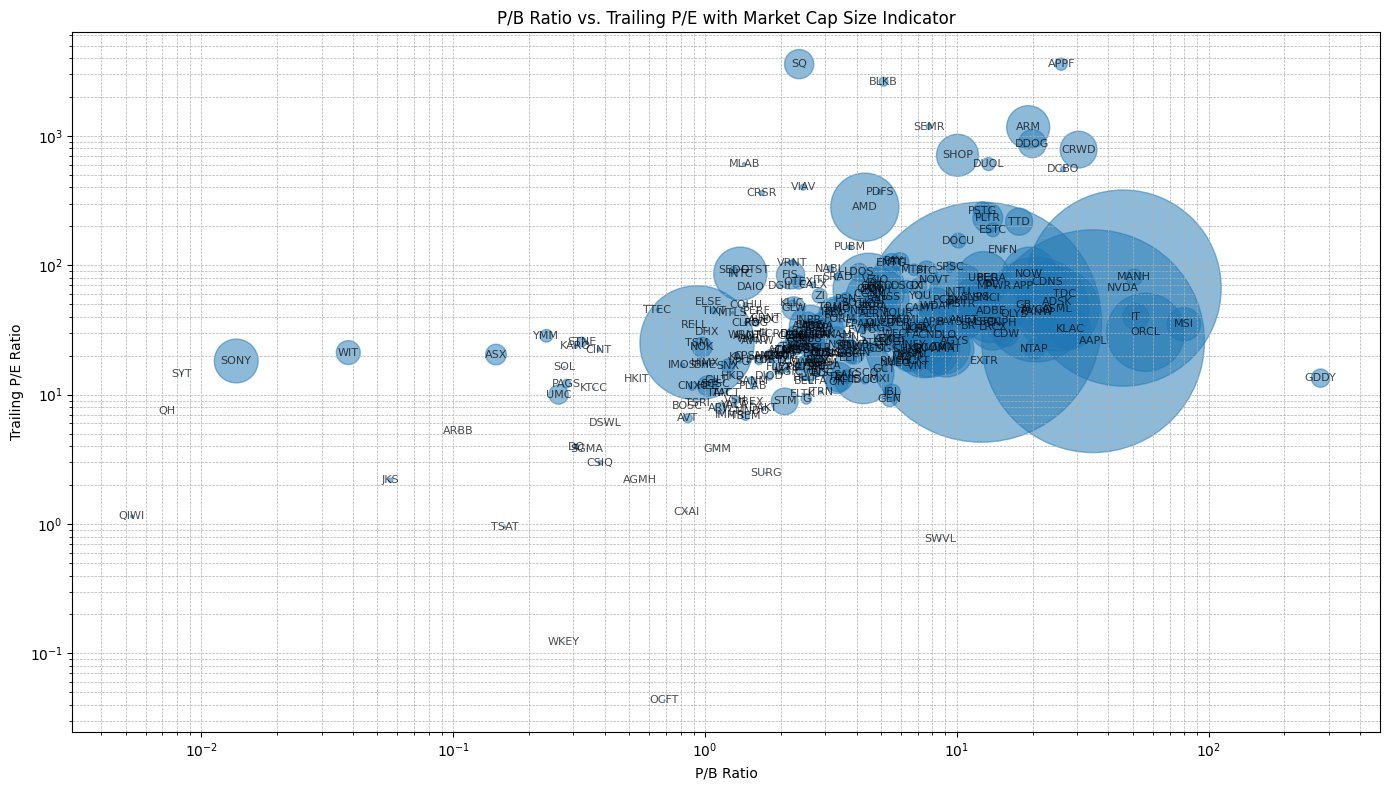

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


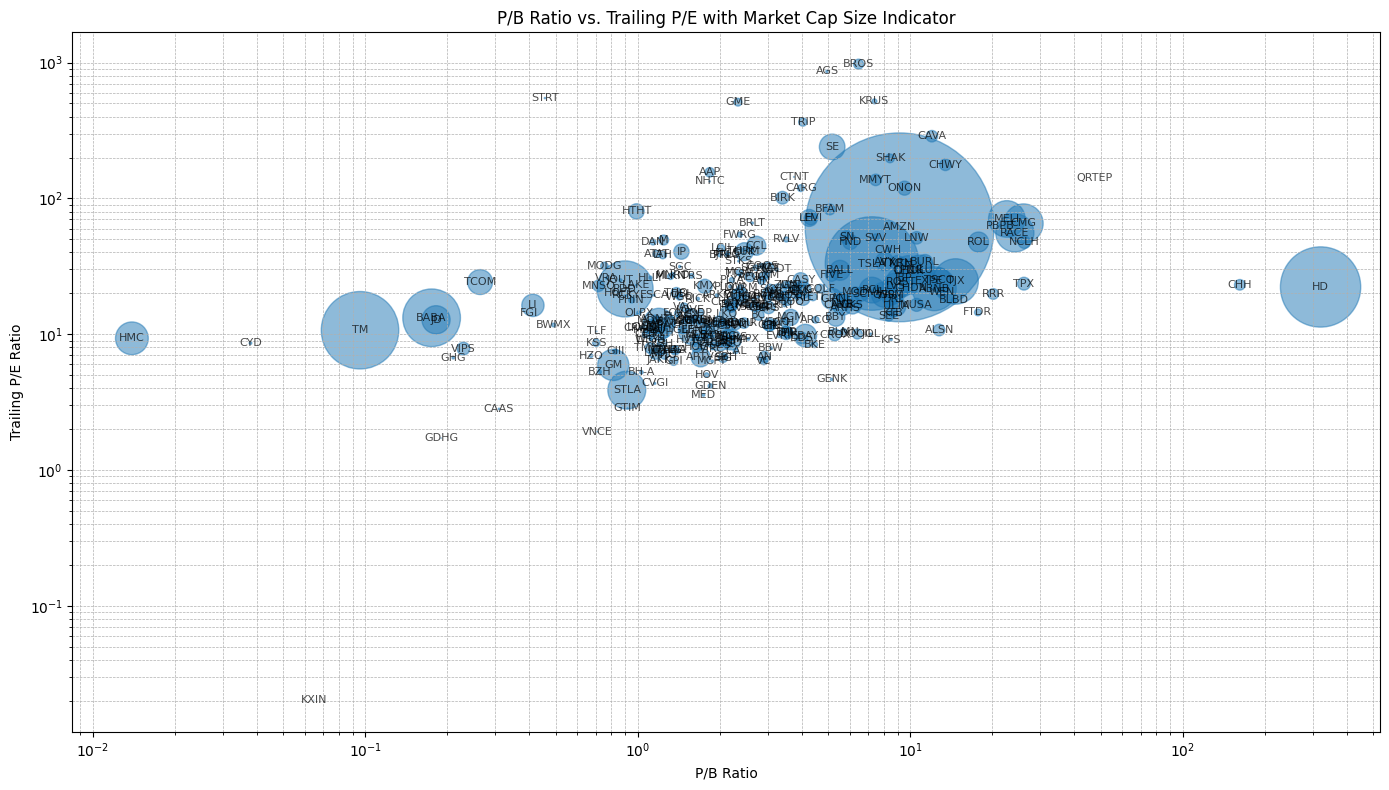

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


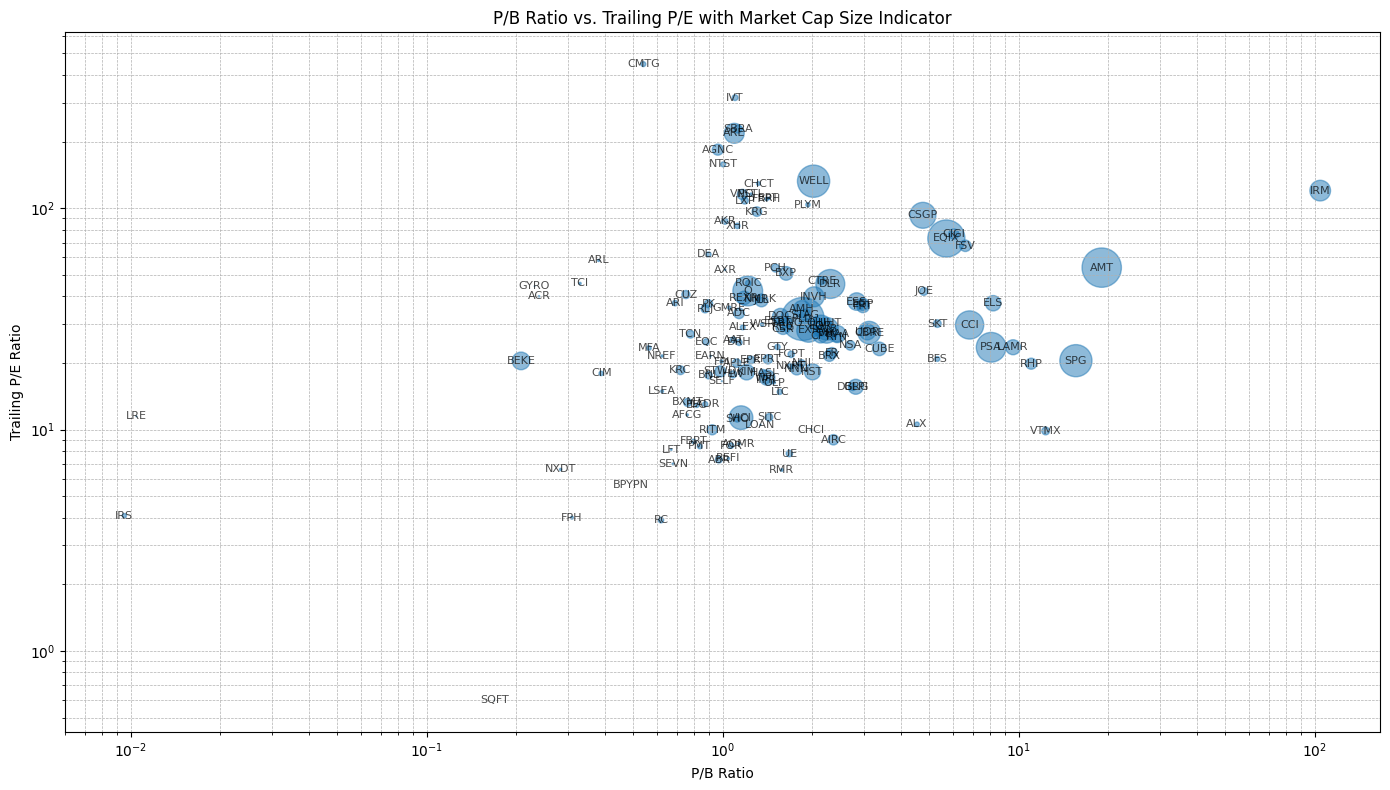

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


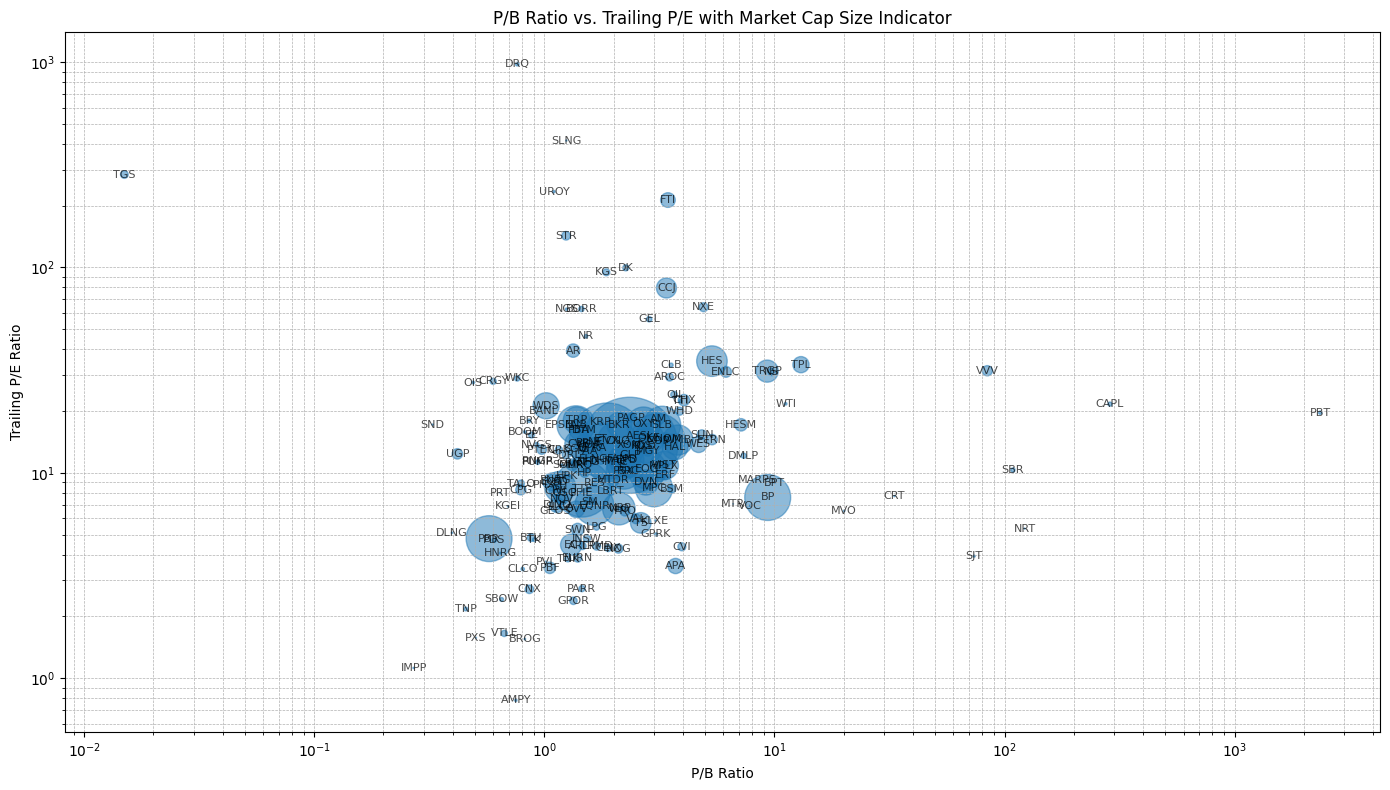

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


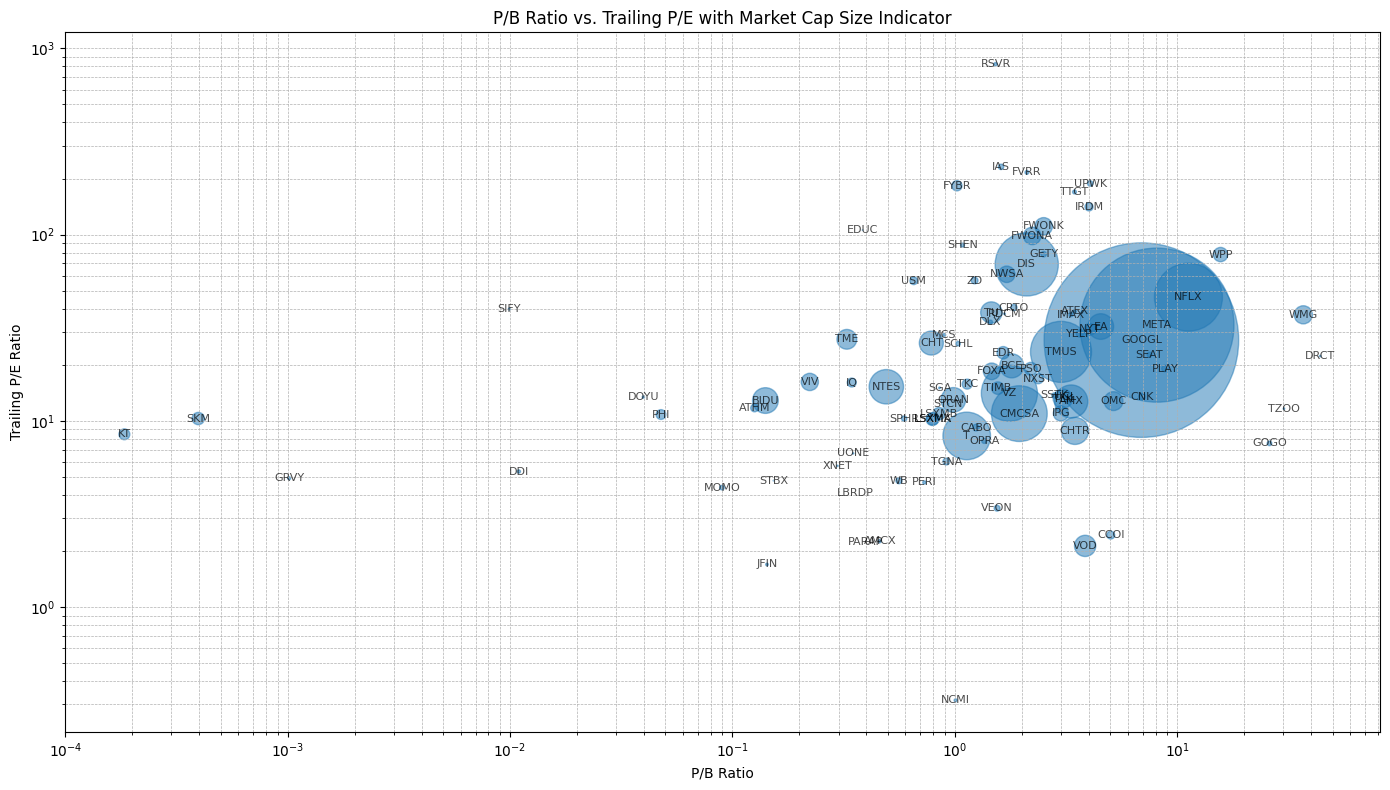

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_10119/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


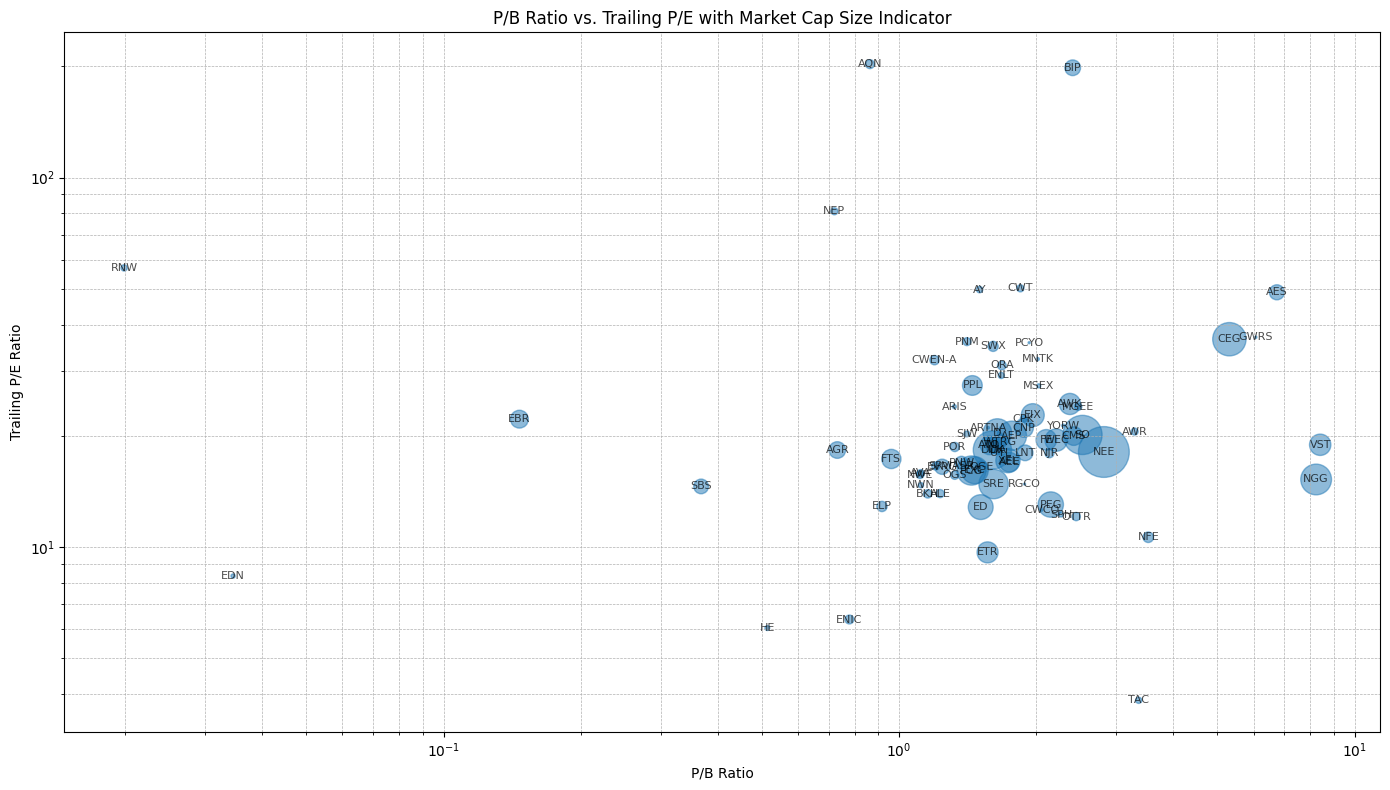

In [23]:
for sector in unique_sectors:
    plot_pe_pb_with_marketcap(sector_results[sector])